In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop
from torchvision.transforms import ToTensor, Normalize
from torchvision.models import vgg16, VGG16_Weights
from tqdm import tqdm

from zennit.attribution import Gradient, SmoothGrad
from zennit.composites import EpsilonGammaBox
from zennit.rules import Epsilon, ZPlus, ZBox, Norm, Pass, Flat

In [3]:
# load the model and set it to evaluation mode
weights = VGG16_Weights.DEFAULT
model = vgg16(weights=weights).eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
# define the base image transform
transform_img = Compose([
    Resize(256),
    CenterCrop(224),
])
# define the normalization transform
transform_norm = Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# define the full tensor transform
transform = Compose([
    transform_img,
    ToTensor(),
    transform_norm,
])

In [5]:
target_labels = [
    0,     # tench
    217,   # English springer
    482,   # cassette player
    491,   # chain saw
    497,   # church
    566,   # French horn
    569,   # garbage truck
    571,   # gas pump
    574,   # golf ball
    701,   # parachute
]

In [6]:
# load the images
import os

imgs_list = []
labels_list = []

parent_dir = os.fsencode("../../external/imagenette2-320/val/")

error_files = []

for i, subdir in enumerate(os.listdir(parent_dir)):
    for file in os.listdir(filedir := os.path.join(parent_dir, subdir)):
        filepath = os.path.join(filedir, file)
        image = Image.open(filepath)

        try:
            # transform the PIL image and insert a batch-dimension
            img_tensor = transform(image)[None]
        except RuntimeError:
            error_files.append(filepath)
            continue

        imgs_list.append(img_tensor)
        labels_list.append(target_labels[i])


In [7]:
len(imgs_list), len(error_files)

(3856, 69)

In [8]:
data = list(zip(imgs_list, labels_list))

# Get attributions from Zennit Saliency, SmoothGrad, and LRP

In [8]:
# Saliency
saliency_attrs = []

# create the attributor, specifying model
with Gradient(model=model) as attributor:
    for img_tensor, label in tqdm(data):
        target = torch.eye(1000)[[label]].to(device)
        # compute the model output and attribution
        output, attribution = attributor(img_tensor.to(device), target)

        # absolute sum over the channels
        relevance = attribution.abs().sum(1).cpu()

        saliency_attrs.append(relevance)
torch.save(torch.stack(saliency_attrs), "vgg_zennit_saliency.pt")

  0%|                                                                                         | 0/3856 [00:00<?, ?it/s]C:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:24<00:00, 156.83it/s]


In [9]:
# SmoothGrad
smoothgrad_attrs = []

# create the attributor, specifying model
with SmoothGrad(noise_level=0.1, n_iter=20, model=model) as attributor:
    for img_tensor, label in tqdm(data):
        target = torch.eye(1000)[[label]].to(device)
        # compute the model output and attribution
        output, attribution = attributor(img_tensor.to(device), target)

        # absolute sum over the channels
        relevance = attribution.abs().sum(1).cpu()

        smoothgrad_attrs.append(relevance)
torch.save(torch.stack(smoothgrad_attrs), "vgg_zennit_smoothgrad.pt")

100%|██████████████████████████████████████████████████████████████████████████████| 3856/3856 [07:13<00:00,  8.90it/s]


In [10]:
# Epsilon-Gamma LRP
lrp_attrs = []

# the EpsilonGammaBox composite needs the lowest and highest values, which are
# here for ImageNet 0. and 1. with a different normalization for each channel
low, high = transform_norm(torch.tensor([[[[[0.]]] * 3], [[[[1.]]] * 3]]))

# create a composite, specifying required arguments
composite = EpsilonGammaBox(low=low, high=high)

# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    for img_tensor, label in tqdm(data):
        target = torch.eye(1000)[[label]].to(device)
        # compute the model output and attribution
        output, attribution = attributor(img_tensor.to(device), target)

        # absolute sum over the channels
        relevance = attribution.abs().sum(1).cpu()

        lrp_attrs.append(relevance)
torch.save(torch.stack(lrp_attrs), "zennitlrp.pt")

100%|██████████████████████████████████████████████████████████████████████████████| 3856/3856 [02:11<00:00, 29.41it/s]


# Get attributions from our LRP

In [9]:
import sys
module_path = os.path.join(os.getcwd(), '..')
sys.path.append(module_path)

In [10]:
from lrp_engine import LRPEngine

In [11]:
img_tensor = data[0][0].to(device).requires_grad_()
output = model(img_tensor)

In [12]:
lrp = LRPEngine(use_gamma=(True, False), conv_gamma=125, params_to_interpret=[ img_tensor ])

In [13]:
lrp_output = lrp.run(output)

In [14]:
ourlrp_attrs = []
for img_tensor, label in tqdm(data):
    # compute the model output and attribution
    output = model(img_tensor.to(device).requires_grad_())
    _, attributions = lrp.run(output)

    # absolute sum over the channels
    relevance = attributions[0].abs().sum(1).cpu()

    ourlrp_attrs.append(relevance)
# torch.save(torch.stack(ourlrp_attrs), "vgg_ourlrp_125_gamma_conv_only_unfiltered.pt")

100%|██████████████████████████████████████████████████████████████████████████████| 3856/3856 [02:56<00:00, 21.79it/s]


# Compare our LRP attributions against theirs

In [15]:
from matplotlib import pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.535425].


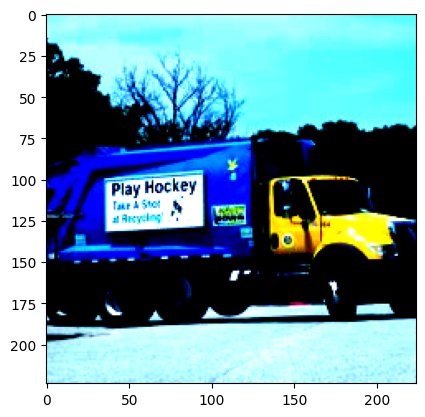

In [16]:
img_ind = 2400
plt.imshow(imgs_list[img_ind][0].permute(1,2,0))

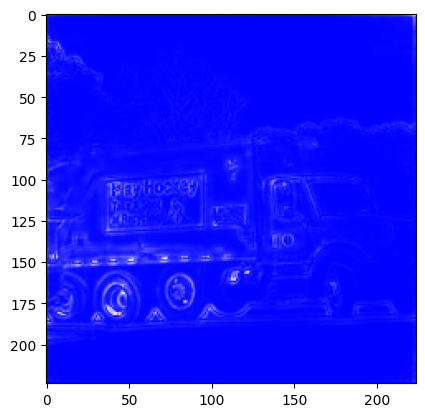

In [19]:
plt.imshow(ourlrp_attrs[img_ind][0], cmap="bwr")

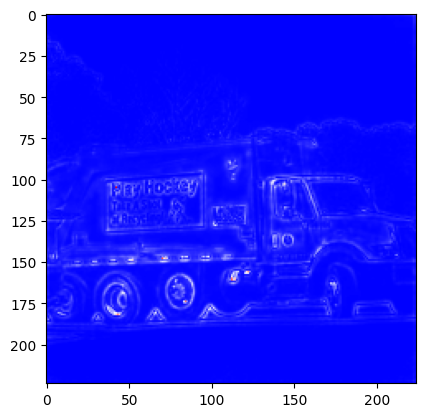

In [22]:
plt.imshow(ourlrp_attrs[img_ind][0], cmap="bwr")

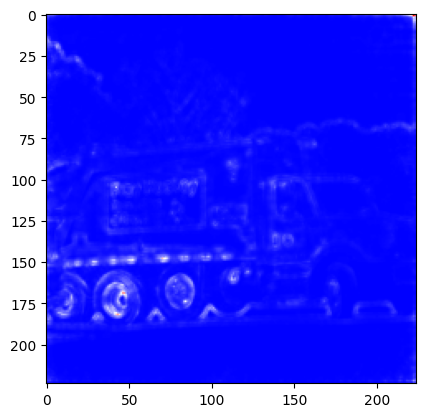

In [59]:
plt.imshow(lrp_heatmaps[img_ind][0], cmap="bwr")

# Setup for MoRF/LeRF evaluation

In [20]:
def evaluateVGG(model, examples, labels):
    pred_idxs = []
    preds = [0, 0]
    data = list(zip(examples, labels))
    for i in tqdm(range(len(examples))):
        img_tensor = examples[i]
        true_label = labels[i]
        img_tensor = img_tensor.to(device)
        # output_tensor, pred_idx = predict(vit_model, img_tensor)
        output = model(img_tensor)
        if isinstance(output, torch.Tensor):
            pred_idx = output.argmax(dim=-1)
        else:
            pred_idx = output.logits.argmax(dim=-1)
        if pred_idx == true_label:
            preds[0] += 1
        else:
            preds[1] += 1

    return preds, pred_idxs, None

In [21]:
# Get baseline
preds0, _, _ = evaluateVGG(model, imgs_list, labels_list)

100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.89it/s]


In [22]:
def get_images(num_samples):
    return [ img.clone() for img, _ in data[:num_samples] ], [ i for _, i in data[:num_samples] ]

In [23]:
img_dims = 224
num_samples = len(data)
occlusion_step = 1024

default_args = {
    "model": model,
    "dims": img_dims,
    "occlusion_step": occlusion_step,
    "num_samples": num_samples,
    "baseline": preds0,
    "eval_fcn": evaluateVGG,
    "image_gen_fcn": get_images,
}

# Run MoRF/LeRF on our LRP

In [24]:
from util import run_morf_lerf_occlusion_pixels

Running 49 occlusion iterations with 1024 pixels each iteration.
Computing baseline...


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 299.50it/s]


Baseline correct/incorrect ratio is [3168, 688]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 299.13it/s]


0 [2802, 1054]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 298.02it/s]


1 [2552, 1304]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 302.24it/s]


2 [2309, 1547]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 300.70it/s]


3 [2108, 1748]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 297.63it/s]


4 [1938, 1918]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 302.57it/s]


5 [1733, 2123]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 302.42it/s]


6 [1561, 2295]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 297.58it/s]


7 [1388, 2468]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 301.09it/s]


8 [1273, 2583]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 301.63it/s]


9 [1143, 2713]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 299.59it/s]


10 [1013, 2843]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 302.89it/s]


11 [875, 2981]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:13<00:00, 295.07it/s]


12 [772, 3084]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 298.35it/s]


13 [677, 3179]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 298.56it/s]


14 [591, 3265]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.67it/s]


15 [540, 3316]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 332.97it/s]


16 [462, 3394]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.48it/s]


17 [412, 3444]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.10it/s]


18 [354, 3502]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.98it/s]


19 [326, 3530]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 335.73it/s]


20 [285, 3571]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.21it/s]


21 [254, 3602]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 335.95it/s]


22 [232, 3624]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 334.30it/s]


23 [212, 3644]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.83it/s]


24 [196, 3660]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.08it/s]


25 [178, 3678]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.80it/s]


26 [160, 3696]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 334.93it/s]


27 [154, 3702]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.71it/s]


28 [133, 3723]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.67it/s]


29 [134, 3722]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 331.22it/s]


30 [129, 3727]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 333.55it/s]


31 [122, 3734]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 335.16it/s]


32 [125, 3731]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.32it/s]


33 [126, 3730]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 334.60it/s]


34 [118, 3738]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 332.65it/s]


35 [113, 3743]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 329.63it/s]


36 [104, 3752]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 316.99it/s]


37 [99, 3757]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.10it/s]


38 [84, 3772]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.19it/s]


39 [87, 3769]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 331.30it/s]


40 [88, 3768]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.07it/s]


41 [86, 3770]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 333.01it/s]


42 [81, 3775]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 334.98it/s]


43 [75, 3781]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.18it/s]


44 [65, 3791]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.12it/s]


45 [55, 3801]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 331.84it/s]


46 [50, 3806]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.48it/s]


47 [36, 3820]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.01it/s]


48 [5, 3851]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.68it/s]


0 [3169, 687]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.74it/s]


1 [3156, 700]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 333.61it/s]


2 [3141, 715]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.43it/s]


3 [3114, 742]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.53it/s]


4 [3113, 743]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.92it/s]


5 [3105, 751]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.43it/s]


6 [3090, 766]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.64it/s]


7 [3084, 772]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 335.18it/s]


8 [3078, 778]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.58it/s]


9 [3058, 798]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.94it/s]


10 [3037, 819]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 335.44it/s]


11 [3006, 850]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 333.61it/s]


12 [2983, 873]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.67it/s]


13 [2973, 883]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.34it/s]


14 [2969, 887]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 333.44it/s]


15 [2942, 914]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.25it/s]


16 [2924, 932]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.67it/s]


17 [2896, 960]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.73it/s]


18 [2873, 983]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.66it/s]


19 [2852, 1004]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.28it/s]


20 [2827, 1029]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.12it/s]


21 [2786, 1070]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.32it/s]


22 [2759, 1097]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.06it/s]


23 [2706, 1150]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.82it/s]


24 [2672, 1184]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.51it/s]


25 [2650, 1206]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.10it/s]


26 [2595, 1261]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.52it/s]


27 [2562, 1294]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.81it/s]


28 [2510, 1346]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.24it/s]


29 [2445, 1411]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.49it/s]


30 [2384, 1472]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.11it/s]


31 [2326, 1530]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.43it/s]


32 [2238, 1618]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.20it/s]


33 [2136, 1720]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.54it/s]


34 [2053, 1803]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.66it/s]


35 [1944, 1912]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.60it/s]


36 [1805, 2051]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.97it/s]


37 [1649, 2207]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.23it/s]


38 [1496, 2360]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.71it/s]


39 [1353, 2503]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.20it/s]


40 [1201, 2655]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 329.98it/s]


41 [1048, 2808]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.08it/s]


42 [858, 2998]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.70it/s]


43 [725, 3131]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.90it/s]


44 [588, 3268]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 334.23it/s]


45 [475, 3381]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 334.58it/s]


46 [368, 3488]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.46it/s]


47 [300, 3556]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 333.69it/s]


48 [5, 3851]


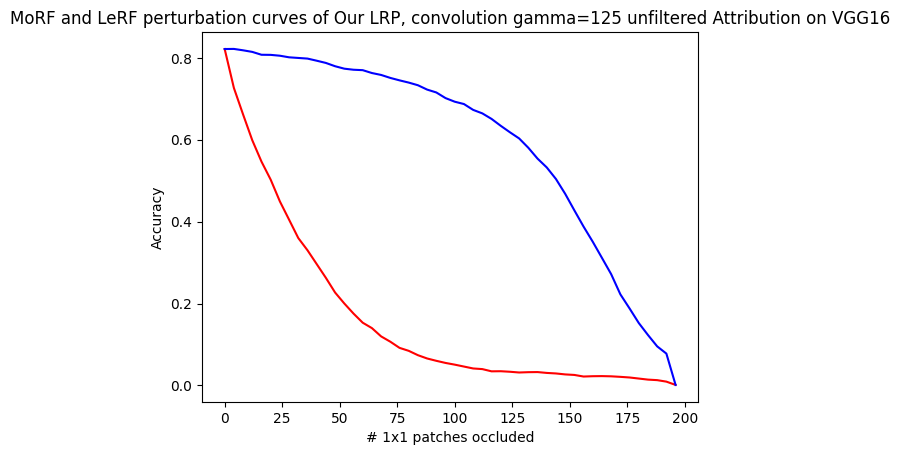

1.770090608857651 2.6512723346600047 0.8811817258023533


([[2802, 1054],
  [2552, 1304],
  [2309, 1547],
  [2108, 1748],
  [1938, 1918],
  [1733, 2123],
  [1561, 2295],
  [1388, 2468],
  [1273, 2583],
  [1143, 2713],
  [1013, 2843],
  [875, 2981],
  [772, 3084],
  [677, 3179],
  [591, 3265],
  [540, 3316],
  [462, 3394],
  [412, 3444],
  [354, 3502],
  [326, 3530],
  [285, 3571],
  [254, 3602],
  [232, 3624],
  [212, 3644],
  [196, 3660],
  [178, 3678],
  [160, 3696],
  [154, 3702],
  [133, 3723],
  [134, 3722],
  [129, 3727],
  [122, 3734],
  [125, 3731],
  [126, 3730],
  [118, 3738],
  [113, 3743],
  [104, 3752],
  [99, 3757],
  [84, 3772],
  [87, 3769],
  [88, 3768],
  [86, 3770],
  [81, 3775],
  [75, 3781],
  [65, 3791],
  [55, 3801],
  [50, 3806],
  [36, 3820],
  [5, 3851]],
 [[3169, 687],
  [3156, 700],
  [3141, 715],
  [3114, 742],
  [3113, 743],
  [3105, 751],
  [3090, 766],
  [3084, 772],
  [3078, 778],
  [3058, 798],
  [3037, 819],
  [3006, 850],
  [2983, 873],
  [2973, 883],
  [2969, 887],
  [2942, 914],
  [2924, 932],
  [2896, 96

In [31]:
run_morf_lerf_occlusion_pixels(heatmaps=ourlrp_attrs, attr_name="Our LRP, convolution gamma=125 unfiltered", **default_args)

Running 49 occlusion iterations with 1024 pixels each iteration.
Baseline correct/incorrect ratio is [3168, 688]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.21it/s]


0 [2787, 1069]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.91it/s]


1 [2519, 1337]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.73it/s]


2 [2313, 1543]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.95it/s]


3 [2113, 1743]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 314.80it/s]


4 [1935, 1921]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 315.44it/s]


5 [1708, 2148]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 318.68it/s]


6 [1573, 2283]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.32it/s]


7 [1378, 2478]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.99it/s]


8 [1222, 2634]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.34it/s]


9 [1101, 2755]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.13it/s]


10 [949, 2907]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 321.11it/s]


11 [820, 3036]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.54it/s]


12 [700, 3156]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.20it/s]


13 [618, 3238]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.57it/s]


14 [521, 3335]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 318.28it/s]


15 [432, 3424]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.47it/s]


16 [376, 3480]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.43it/s]


17 [318, 3538]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 317.98it/s]


18 [296, 3560]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.65it/s]


19 [261, 3595]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.16it/s]


20 [231, 3625]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 318.30it/s]


21 [206, 3650]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.86it/s]


22 [178, 3678]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.70it/s]


23 [163, 3693]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.45it/s]


24 [149, 3707]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.07it/s]


25 [119, 3737]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.29it/s]


26 [97, 3759]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.23it/s]


27 [90, 3766]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.15it/s]


28 [86, 3770]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.08it/s]


29 [76, 3780]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.78it/s]


30 [73, 3783]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 329.42it/s]


31 [67, 3789]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.08it/s]


32 [58, 3798]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.11it/s]


33 [58, 3798]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:14<00:00, 267.12it/s]


34 [61, 3795]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 321.04it/s]


35 [57, 3799]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 321.27it/s]


36 [51, 3805]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.01it/s]


37 [48, 3808]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.64it/s]


38 [44, 3812]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.74it/s]


39 [42, 3814]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.44it/s]


40 [38, 3818]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 321.15it/s]


41 [31, 3825]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.98it/s]


42 [32, 3824]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.73it/s]


43 [26, 3830]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 321.31it/s]


44 [23, 3833]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.73it/s]


45 [13, 3843]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.72it/s]


46 [13, 3843]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 318.99it/s]


47 [14, 3842]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.77it/s]


48 [5, 3851]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.12it/s]


0 [3174, 682]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.46it/s]


1 [3158, 698]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.58it/s]


2 [3148, 708]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.29it/s]


3 [3143, 713]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.43it/s]


4 [3131, 725]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.44it/s]


5 [3127, 729]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.26it/s]


6 [3117, 739]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.14it/s]


7 [3098, 758]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.79it/s]


8 [3069, 787]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.76it/s]


9 [3062, 794]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.10it/s]


10 [3030, 826]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.92it/s]


11 [3013, 843]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.60it/s]


12 [2984, 872]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.47it/s]


13 [2945, 911]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.32it/s]


14 [2934, 922]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.64it/s]


15 [2923, 933]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.17it/s]


16 [2891, 965]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.70it/s]


17 [2859, 997]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.58it/s]


18 [2831, 1025]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.01it/s]


19 [2802, 1054]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.87it/s]


20 [2752, 1104]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.16it/s]


21 [2739, 1117]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.97it/s]


22 [2686, 1170]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.60it/s]


23 [2653, 1203]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.25it/s]


24 [2593, 1263]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.99it/s]


25 [2551, 1305]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 313.08it/s]


26 [2492, 1364]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 312.14it/s]


27 [2410, 1446]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.34it/s]


28 [2358, 1498]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.36it/s]


29 [2313, 1543]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.71it/s]


30 [2240, 1616]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 318.64it/s]


31 [2148, 1708]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.27it/s]


32 [2054, 1802]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.51it/s]


33 [1950, 1906]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.39it/s]


34 [1834, 2022]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.62it/s]


35 [1712, 2144]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 318.53it/s]


36 [1585, 2271]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.76it/s]


37 [1444, 2412]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.36it/s]


38 [1305, 2551]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.66it/s]


39 [1165, 2691]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.96it/s]


40 [1018, 2838]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.89it/s]


41 [857, 2999]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.90it/s]


42 [728, 3128]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.44it/s]


43 [596, 3260]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.66it/s]


44 [482, 3374]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.30it/s]


45 [396, 3460]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.89it/s]


46 [327, 3529]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.14it/s]


47 [279, 3577]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.22it/s]


48 [5, 3851]


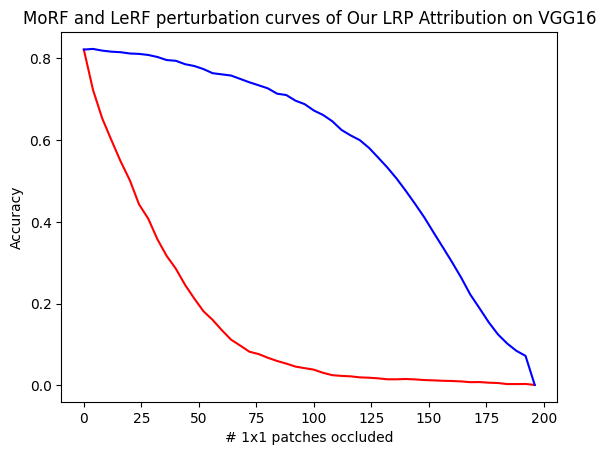

1.7364298416462018 2.7005144381404005 0.964084596494199


([[2787, 1069],
  [2519, 1337],
  [2313, 1543],
  [2113, 1743],
  [1935, 1921],
  [1708, 2148],
  [1573, 2283],
  [1378, 2478],
  [1222, 2634],
  [1101, 2755],
  [949, 2907],
  [820, 3036],
  [700, 3156],
  [618, 3238],
  [521, 3335],
  [432, 3424],
  [376, 3480],
  [318, 3538],
  [296, 3560],
  [261, 3595],
  [231, 3625],
  [206, 3650],
  [178, 3678],
  [163, 3693],
  [149, 3707],
  [119, 3737],
  [97, 3759],
  [90, 3766],
  [86, 3770],
  [76, 3780],
  [73, 3783],
  [67, 3789],
  [58, 3798],
  [58, 3798],
  [61, 3795],
  [57, 3799],
  [51, 3805],
  [48, 3808],
  [44, 3812],
  [42, 3814],
  [38, 3818],
  [31, 3825],
  [32, 3824],
  [26, 3830],
  [23, 3833],
  [13, 3843],
  [13, 3843],
  [14, 3842],
  [5, 3851]],
 [[3174, 682],
  [3158, 698],
  [3148, 708],
  [3143, 713],
  [3131, 725],
  [3127, 729],
  [3117, 739],
  [3098, 758],
  [3069, 787],
  [3062, 794],
  [3030, 826],
  [3013, 843],
  [2984, 872],
  [2945, 911],
  [2934, 922],
  [2923, 933],
  [2891, 965],
  [2859, 997],
  [2831,

In [23]:
run_morf_lerf_occlusion_pixels(heatmaps=ourlrp_attrs, attr_name="Our LRP", **default_args)

In [16]:
del ourlrp_attrs

# Run MoRF/LeRF on other attributions

In [22]:
lrp_heatmaps = torch.load("vgg_zennit_lrp.pt")

Running 49 occlusion iterations with 1024 pixels each iteration.
Baseline correct/incorrect ratio is [3168, 688]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.63it/s]


0 [2803, 1053]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.73it/s]


1 [2493, 1363]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.04it/s]


2 [2228, 1628]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.44it/s]


3 [1998, 1858]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.17it/s]


4 [1800, 2056]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.17it/s]


5 [1569, 2287]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 312.02it/s]


6 [1360, 2496]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 316.76it/s]


7 [1181, 2675]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 314.31it/s]


8 [1034, 2822]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 317.73it/s]


9 [881, 2975]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 308.39it/s]


10 [771, 3085]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 316.60it/s]


11 [669, 3187]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.79it/s]


12 [567, 3289]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 317.92it/s]


13 [490, 3366]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.49it/s]


14 [420, 3436]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.51it/s]


15 [370, 3486]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 307.31it/s]


16 [330, 3526]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 316.78it/s]


17 [294, 3562]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 314.94it/s]


18 [267, 3589]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 318.66it/s]


19 [239, 3617]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.57it/s]


20 [221, 3635]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 316.28it/s]


21 [209, 3647]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 317.23it/s]


22 [204, 3652]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 315.18it/s]


23 [179, 3677]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 309.10it/s]


24 [165, 3691]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 308.54it/s]


25 [164, 3692]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 314.95it/s]


26 [148, 3708]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 307.37it/s]


27 [147, 3709]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 321.19it/s]


28 [143, 3713]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.45it/s]


29 [134, 3722]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.78it/s]


30 [145, 3711]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.58it/s]


31 [124, 3732]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.74it/s]


32 [123, 3733]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.26it/s]


33 [125, 3731]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 318.30it/s]


34 [115, 3741]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.36it/s]


35 [110, 3746]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.64it/s]


36 [98, 3758]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.36it/s]


37 [107, 3749]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.79it/s]


38 [104, 3752]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.47it/s]


39 [106, 3750]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.69it/s]


40 [103, 3753]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 321.20it/s]


41 [103, 3753]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.47it/s]


42 [106, 3750]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.88it/s]


43 [83, 3773]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 318.03it/s]


44 [73, 3783]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.79it/s]


45 [70, 3786]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 317.05it/s]


46 [55, 3801]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.83it/s]


47 [46, 3810]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.46it/s]


48 [5, 3851]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.88it/s]


0 [3151, 705]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 318.88it/s]


1 [3132, 724]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 321.27it/s]


2 [3108, 748]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 317.90it/s]


3 [3107, 749]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.00it/s]


4 [3081, 775]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 317.13it/s]


5 [3065, 791]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.95it/s]


6 [3048, 808]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 318.95it/s]


7 [3019, 837]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.51it/s]


8 [2999, 857]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 318.75it/s]


9 [2969, 887]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.02it/s]


10 [2942, 914]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.98it/s]


11 [2909, 947]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.49it/s]


12 [2900, 956]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.14it/s]


13 [2852, 1004]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.82it/s]


14 [2839, 1017]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.67it/s]


15 [2826, 1030]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 312.94it/s]


16 [2800, 1056]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 318.50it/s]


17 [2762, 1094]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.58it/s]


18 [2735, 1121]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.14it/s]


19 [2716, 1140]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.44it/s]


20 [2661, 1195]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.92it/s]


21 [2628, 1228]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.28it/s]


22 [2595, 1261]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.77it/s]


23 [2557, 1299]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.97it/s]


24 [2533, 1323]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 318.85it/s]


25 [2469, 1387]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 321.29it/s]


26 [2432, 1424]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.16it/s]


27 [2360, 1496]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 318.59it/s]


28 [2298, 1558]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.76it/s]


29 [2238, 1618]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 318.91it/s]


30 [2171, 1685]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.51it/s]


31 [2084, 1772]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.54it/s]


32 [1984, 1872]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 309.04it/s]


33 [1884, 1972]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 303.93it/s]


34 [1789, 2067]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 307.16it/s]


35 [1655, 2201]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 305.81it/s]


36 [1530, 2326]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 308.75it/s]


37 [1385, 2471]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 307.54it/s]


38 [1242, 2614]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 307.69it/s]


39 [1121, 2735]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 304.66it/s]


40 [981, 2875]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 296.67it/s]


41 [841, 3015]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 300.19it/s]


42 [708, 3148]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 308.30it/s]


43 [609, 3247]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 305.78it/s]


44 [506, 3350]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 298.81it/s]


45 [415, 3441]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 310.27it/s]


46 [358, 3498]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 303.55it/s]


47 [317, 3539]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 309.78it/s]

48 [5, 3851]


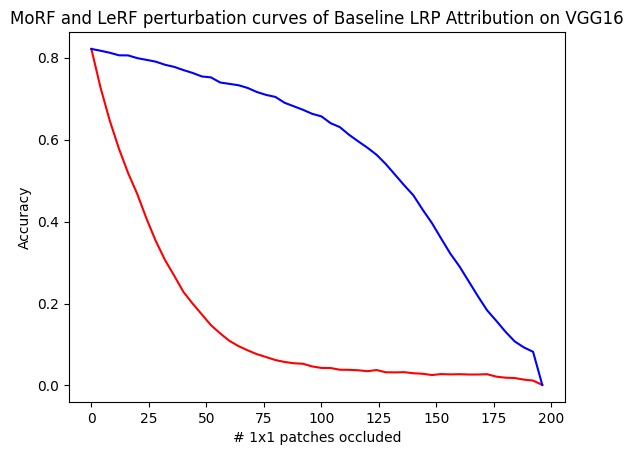

1.6944068083665 2.7176623761537804 1.0232555677872803


([[2803, 1053],
  [2493, 1363],
  [2228, 1628],
  [1998, 1858],
  [1800, 2056],
  [1569, 2287],
  [1360, 2496],
  [1181, 2675],
  [1034, 2822],
  [881, 2975],
  [771, 3085],
  [669, 3187],
  [567, 3289],
  [490, 3366],
  [420, 3436],
  [370, 3486],
  [330, 3526],
  [294, 3562],
  [267, 3589],
  [239, 3617],
  [221, 3635],
  [209, 3647],
  [204, 3652],
  [179, 3677],
  [165, 3691],
  [164, 3692],
  [148, 3708],
  [147, 3709],
  [143, 3713],
  [134, 3722],
  [145, 3711],
  [124, 3732],
  [123, 3733],
  [125, 3731],
  [115, 3741],
  [110, 3746],
  [98, 3758],
  [107, 3749],
  [104, 3752],
  [106, 3750],
  [103, 3753],
  [103, 3753],
  [106, 3750],
  [83, 3773],
  [73, 3783],
  [70, 3786],
  [55, 3801],
  [46, 3810],
  [5, 3851]],
 [[3151, 705],
  [3132, 724],
  [3108, 748],
  [3107, 749],
  [3081, 775],
  [3065, 791],
  [3048, 808],
  [3019, 837],
  [2999, 857],
  [2969, 887],
  [2942, 914],
  [2909, 947],
  [2900, 956],
  [2852, 1004],
  [2839, 1017],
  [2826, 1030],
  [2800, 1056],
  [2

In [23]:
run_morf_lerf_occlusion_pixels(heatmaps=lrp_heatmaps, attr_name="Baseline LRP", **default_args)

In [24]:
del lrp_heatmaps

In [13]:
saliency_heatmaps = torch.load("vgg_zennit_saliency.pt")

Running 49 occlusion iterations with 1024 pixels each iteration.
Baseline correct/incorrect ratio is [3168, 688]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.56it/s]


0 [2784, 1072]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.50it/s]


1 [2518, 1338]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.68it/s]


2 [2307, 1549]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 329.97it/s]


3 [2111, 1745]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 333.12it/s]


4 [1946, 1910]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.51it/s]


5 [1817, 2039]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.14it/s]


6 [1673, 2183]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 334.95it/s]


7 [1560, 2296]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.04it/s]


8 [1428, 2428]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 333.90it/s]


9 [1333, 2523]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.47it/s]


10 [1231, 2625]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.02it/s]


11 [1129, 2727]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.16it/s]


12 [1014, 2842]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.92it/s]


13 [947, 2909]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.63it/s]


14 [841, 3015]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 335.90it/s]


15 [787, 3069]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.25it/s]


16 [698, 3158]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.09it/s]


17 [631, 3225]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.44it/s]


18 [559, 3297]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.81it/s]


19 [486, 3370]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.01it/s]


20 [443, 3413]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.36it/s]


21 [381, 3475]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.23it/s]


22 [353, 3503]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.45it/s]


23 [313, 3543]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.43it/s]


24 [269, 3587]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.16it/s]


25 [232, 3624]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.94it/s]


26 [206, 3650]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.96it/s]


27 [183, 3673]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.80it/s]


28 [166, 3690]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.29it/s]


29 [150, 3706]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.47it/s]


30 [134, 3722]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.50it/s]


31 [113, 3743]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.00it/s]


32 [103, 3753]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.23it/s]


33 [87, 3769]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.78it/s]


34 [83, 3773]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.35it/s]


35 [73, 3783]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.22it/s]


36 [66, 3790]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.79it/s]


37 [63, 3793]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.33it/s]


38 [63, 3793]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.59it/s]


39 [62, 3794]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.53it/s]


40 [61, 3795]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.51it/s]


41 [60, 3796]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.28it/s]


42 [63, 3793]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.61it/s]


43 [57, 3799]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.10it/s]


44 [59, 3797]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.26it/s]


45 [54, 3802]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.85it/s]


46 [55, 3801]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.56it/s]


47 [50, 3806]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.47it/s]


48 [5, 3851]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.32it/s]


0 [3093, 763]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.61it/s]


1 [3059, 797]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.74it/s]


2 [2989, 867]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.08it/s]


3 [2946, 910]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.04it/s]


4 [2896, 960]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.50it/s]


5 [2853, 1003]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.51it/s]


6 [2788, 1068]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.60it/s]


7 [2739, 1117]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.22it/s]


8 [2687, 1169]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.94it/s]


9 [2613, 1243]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.33it/s]


10 [2558, 1298]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.89it/s]


11 [2447, 1409]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.37it/s]


12 [2390, 1466]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.25it/s]


13 [2297, 1559]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.76it/s]


14 [2203, 1653]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.05it/s]


15 [2117, 1739]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.13it/s]


16 [2033, 1823]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.87it/s]


17 [1933, 1923]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.64it/s]


18 [1816, 2040]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.43it/s]


19 [1728, 2128]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.84it/s]


20 [1608, 2248]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.96it/s]


21 [1506, 2350]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.06it/s]


22 [1411, 2445]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.97it/s]


23 [1298, 2558]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.51it/s]


24 [1196, 2660]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.03it/s]


25 [1076, 2780]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.60it/s]


26 [987, 2869]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.93it/s]


27 [881, 2975]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.78it/s]


28 [782, 3074]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.53it/s]


29 [719, 3137]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.09it/s]


30 [644, 3212]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.58it/s]


31 [551, 3305]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.11it/s]


32 [491, 3365]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.41it/s]


33 [440, 3416]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.99it/s]


34 [391, 3465]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.97it/s]


35 [335, 3521]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.49it/s]


36 [297, 3559]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.03it/s]


37 [249, 3607]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.11it/s]


38 [223, 3633]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.47it/s]


39 [186, 3670]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.76it/s]


40 [142, 3714]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.20it/s]


41 [126, 3730]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.32it/s]


42 [111, 3745]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.01it/s]


43 [90, 3766]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.40it/s]


44 [73, 3783]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.08it/s]


45 [67, 3789]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.00it/s]


46 [62, 3794]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.13it/s]


47 [76, 3780]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.03it/s]


48 [5, 3851]


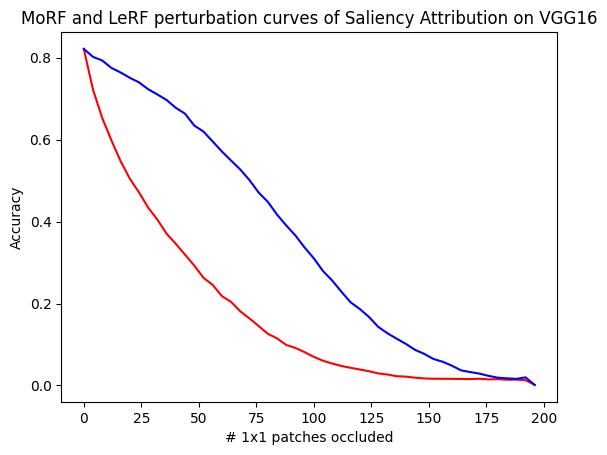

0.7282792785163857 2.5794626979422466 1.851183419425861


([[2784, 1072],
  [2518, 1338],
  [2307, 1549],
  [2111, 1745],
  [1946, 1910],
  [1817, 2039],
  [1673, 2183],
  [1560, 2296],
  [1428, 2428],
  [1333, 2523],
  [1231, 2625],
  [1129, 2727],
  [1014, 2842],
  [947, 2909],
  [841, 3015],
  [787, 3069],
  [698, 3158],
  [631, 3225],
  [559, 3297],
  [486, 3370],
  [443, 3413],
  [381, 3475],
  [353, 3503],
  [313, 3543],
  [269, 3587],
  [232, 3624],
  [206, 3650],
  [183, 3673],
  [166, 3690],
  [150, 3706],
  [134, 3722],
  [113, 3743],
  [103, 3753],
  [87, 3769],
  [83, 3773],
  [73, 3783],
  [66, 3790],
  [63, 3793],
  [63, 3793],
  [62, 3794],
  [61, 3795],
  [60, 3796],
  [63, 3793],
  [57, 3799],
  [59, 3797],
  [54, 3802],
  [55, 3801],
  [50, 3806],
  [5, 3851]],
 [[3093, 763],
  [3059, 797],
  [2989, 867],
  [2946, 910],
  [2896, 960],
  [2853, 1003],
  [2788, 1068],
  [2739, 1117],
  [2687, 1169],
  [2613, 1243],
  [2558, 1298],
  [2447, 1409],
  [2390, 1466],
  [2297, 1559],
  [2203, 1653],
  [2117, 1739],
  [2033, 1823],
 

In [17]:
run_morf_lerf_occlusion_pixels(heatmaps=saliency_heatmaps, attr_name="Saliency", **default_args)

In [18]:
del saliency_heatmaps

In [19]:
smoothgrad_heatmaps = torch.load("vgg_zennit_smoothgrad.pt")

Running 49 occlusion iterations with 1024 pixels each iteration.
Baseline correct/incorrect ratio is [3168, 688]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.57it/s]


0 [2569, 1287]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.32it/s]


1 [2164, 1692]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.00it/s]


2 [1882, 1974]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 330.52it/s]


3 [1614, 2242]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 333.17it/s]


4 [1389, 2467]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 335.33it/s]


5 [1196, 2660]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 335.77it/s]


6 [1021, 2835]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 335.61it/s]


7 [876, 2980]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.07it/s]


8 [744, 3112]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 335.65it/s]


9 [626, 3230]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.34it/s]


10 [528, 3328]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.74it/s]


11 [445, 3411]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.48it/s]


12 [337, 3519]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.33it/s]


13 [268, 3588]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.72it/s]


14 [231, 3625]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.29it/s]


15 [191, 3665]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.76it/s]


16 [157, 3699]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.76it/s]


17 [128, 3728]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.61it/s]


18 [120, 3736]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 334.68it/s]


19 [94, 3762]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.99it/s]


20 [91, 3765]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.72it/s]


21 [77, 3779]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.55it/s]


22 [66, 3790]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.17it/s]


23 [59, 3797]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.89it/s]


24 [49, 3807]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.59it/s]


25 [54, 3802]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.93it/s]


26 [45, 3811]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.33it/s]


27 [41, 3815]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 335.97it/s]


28 [33, 3823]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.29it/s]


29 [38, 3818]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.45it/s]


30 [38, 3818]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.74it/s]


31 [41, 3815]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.82it/s]


32 [37, 3819]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.37it/s]


33 [33, 3823]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.96it/s]


34 [40, 3816]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.91it/s]


35 [37, 3819]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.48it/s]


36 [38, 3818]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.74it/s]


37 [38, 3818]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.71it/s]


38 [43, 3813]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.21it/s]


39 [48, 3808]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.07it/s]


40 [52, 3804]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.10it/s]


41 [54, 3802]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.92it/s]


42 [51, 3805]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 333.79it/s]


43 [54, 3802]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.25it/s]


44 [55, 3801]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.22it/s]


45 [57, 3799]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.79it/s]


46 [53, 3803]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.31it/s]


47 [45, 3811]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.51it/s]


48 [5, 3851]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.56it/s]


0 [3116, 740]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.58it/s]


1 [3076, 780]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.83it/s]


2 [3049, 807]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.58it/s]


3 [3002, 854]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.77it/s]


4 [2987, 869]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.01it/s]


5 [2956, 900]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.27it/s]


6 [2931, 925]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.83it/s]


7 [2887, 969]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.94it/s]


8 [2849, 1007]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.23it/s]


9 [2821, 1035]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.46it/s]


10 [2787, 1069]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.26it/s]


11 [2743, 1113]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.22it/s]


12 [2690, 1166]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.01it/s]


13 [2647, 1209]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.19it/s]


14 [2605, 1251]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.42it/s]


15 [2550, 1306]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.30it/s]


16 [2499, 1357]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.00it/s]


17 [2468, 1388]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.10it/s]


18 [2409, 1447]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.69it/s]


19 [2347, 1509]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.78it/s]


20 [2300, 1556]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.81it/s]


21 [2249, 1607]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.73it/s]


22 [2179, 1677]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.52it/s]


23 [2109, 1747]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.69it/s]


24 [2039, 1817]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.34it/s]


25 [1967, 1889]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.33it/s]


26 [1899, 1957]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.26it/s]


27 [1806, 2050]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.66it/s]


28 [1734, 2122]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.87it/s]


29 [1641, 2215]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.56it/s]


30 [1544, 2312]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.04it/s]


31 [1466, 2390]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.77it/s]


32 [1367, 2489]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.01it/s]


33 [1250, 2606]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.09it/s]


34 [1150, 2706]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.36it/s]


35 [1040, 2816]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.76it/s]


36 [940, 2916]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.22it/s]


37 [827, 3029]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.92it/s]


38 [736, 3120]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.82it/s]


39 [635, 3221]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.01it/s]


40 [546, 3310]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.22it/s]


41 [468, 3388]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.00it/s]


42 [364, 3492]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.09it/s]


43 [304, 3552]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.28it/s]


44 [248, 3608]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.45it/s]


45 [194, 3662]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.45it/s]


46 [166, 3690]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.73it/s]


47 [157, 3699]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.02it/s]

48 [5, 3851]


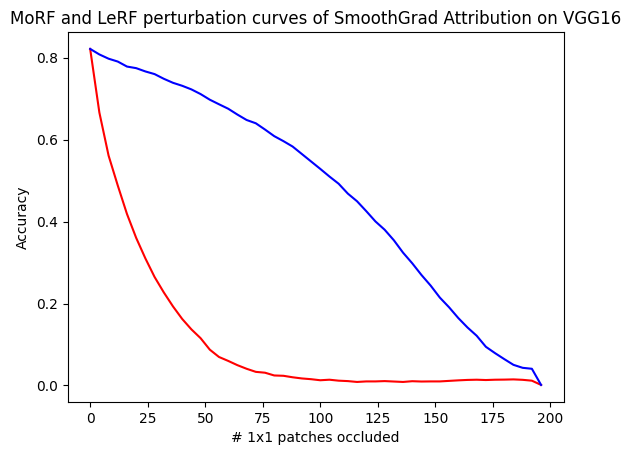

1.4987932932509105 2.8727771191464133 1.3739838258955026


([[2569, 1287],
  [2164, 1692],
  [1882, 1974],
  [1614, 2242],
  [1389, 2467],
  [1196, 2660],
  [1021, 2835],
  [876, 2980],
  [744, 3112],
  [626, 3230],
  [528, 3328],
  [445, 3411],
  [337, 3519],
  [268, 3588],
  [231, 3625],
  [191, 3665],
  [157, 3699],
  [128, 3728],
  [120, 3736],
  [94, 3762],
  [91, 3765],
  [77, 3779],
  [66, 3790],
  [59, 3797],
  [49, 3807],
  [54, 3802],
  [45, 3811],
  [41, 3815],
  [33, 3823],
  [38, 3818],
  [38, 3818],
  [41, 3815],
  [37, 3819],
  [33, 3823],
  [40, 3816],
  [37, 3819],
  [38, 3818],
  [38, 3818],
  [43, 3813],
  [48, 3808],
  [52, 3804],
  [54, 3802],
  [51, 3805],
  [54, 3802],
  [55, 3801],
  [57, 3799],
  [53, 3803],
  [45, 3811],
  [5, 3851]],
 [[3116, 740],
  [3076, 780],
  [3049, 807],
  [3002, 854],
  [2987, 869],
  [2956, 900],
  [2931, 925],
  [2887, 969],
  [2849, 1007],
  [2821, 1035],
  [2787, 1069],
  [2743, 1113],
  [2690, 1166],
  [2647, 1209],
  [2605, 1251],
  [2550, 1306],
  [2499, 1357],
  [2468, 1388],
  [2409,

In [20]:
run_morf_lerf_occlusion_pixels(heatmaps=smoothgrad_heatmaps, attr_name="SmoothGrad", **default_args)

In [21]:
del smoothgrad_heatmaps

In [14]:
# Random
random_attrs = torch.rand((len(data), 1, 3, 224, 224), device=device)

Running 49 occlusion iterations with 1024 pixels each iteration.
Computing baseline...


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.01it/s]


Baseline correct/incorrect ratio is [3168, 688]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 334.68it/s]


0 [2925, 931]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 332.58it/s]


1 [2752, 1104]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 332.64it/s]


2 [2632, 1224]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.79it/s]


3 [2481, 1375]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.56it/s]


4 [2339, 1517]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.23it/s]


5 [2193, 1663]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 335.59it/s]


6 [2043, 1813]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.48it/s]


7 [1902, 1954]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.82it/s]


8 [1785, 2071]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.67it/s]


9 [1670, 2186]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.41it/s]


10 [1563, 2293]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.94it/s]


11 [1459, 2397]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.18it/s]


12 [1354, 2502]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 334.32it/s]


13 [1264, 2592]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.24it/s]


14 [1190, 2666]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.07it/s]


15 [1131, 2725]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 333.94it/s]


16 [1054, 2802]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.48it/s]


17 [982, 2874]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.18it/s]


18 [890, 2966]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.12it/s]


19 [822, 3034]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.11it/s]


20 [769, 3087]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.80it/s]


21 [696, 3160]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.09it/s]


22 [624, 3232]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 331.86it/s]


23 [543, 3313]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.79it/s]


24 [485, 3371]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.22it/s]


25 [430, 3426]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.52it/s]


26 [372, 3484]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 312.50it/s]


27 [305, 3551]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.38it/s]


28 [258, 3598]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.60it/s]


29 [228, 3628]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 318.53it/s]


30 [187, 3669]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.23it/s]


31 [160, 3696]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 321.30it/s]


32 [126, 3730]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 314.51it/s]


33 [99, 3757]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.19it/s]


34 [78, 3778]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.43it/s]


35 [66, 3790]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 317.33it/s]


36 [52, 3804]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.00it/s]


37 [43, 3813]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 317.44it/s]


38 [36, 3820]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.07it/s]


39 [32, 3824]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.73it/s]


40 [36, 3820]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 318.86it/s]


41 [37, 3819]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.21it/s]


42 [32, 3824]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.00it/s]


43 [34, 3822]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.72it/s]


44 [33, 3823]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.51it/s]


45 [40, 3816]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.78it/s]


46 [48, 3808]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.80it/s]


47 [52, 3804]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 317.27it/s]


48 [5, 3851]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.19it/s]


0 [2922, 934]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.81it/s]


1 [2764, 1092]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.29it/s]


2 [2615, 1241]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.69it/s]


3 [2474, 1382]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.02it/s]


4 [2329, 1527]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.60it/s]


5 [2204, 1652]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.80it/s]


6 [2058, 1798]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.96it/s]


7 [1912, 1944]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.91it/s]


8 [1787, 2069]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.41it/s]


9 [1661, 2195]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.17it/s]


10 [1563, 2293]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.74it/s]


11 [1469, 2387]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.01it/s]


12 [1385, 2471]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.17it/s]


13 [1278, 2578]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.31it/s]


14 [1196, 2660]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.48it/s]


15 [1131, 2725]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.24it/s]


16 [1046, 2810]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.48it/s]


17 [978, 2878]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.01it/s]


18 [888, 2968]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.42it/s]


19 [824, 3032]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.78it/s]


20 [748, 3108]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.37it/s]


21 [674, 3182]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.19it/s]


22 [599, 3257]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.32it/s]


23 [515, 3341]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.21it/s]


24 [466, 3390]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.12it/s]


25 [408, 3448]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.71it/s]


26 [357, 3499]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.95it/s]


27 [311, 3545]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.85it/s]


28 [261, 3595]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.50it/s]


29 [219, 3637]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.93it/s]


30 [185, 3671]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.93it/s]


31 [154, 3702]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.41it/s]


32 [127, 3729]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.62it/s]


33 [103, 3753]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.37it/s]


34 [89, 3767]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.81it/s]


35 [61, 3795]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.86it/s]


36 [52, 3804]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.92it/s]


37 [44, 3812]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 321.85it/s]


38 [36, 3820]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.56it/s]


39 [36, 3820]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.54it/s]


40 [36, 3820]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.08it/s]


41 [35, 3821]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.87it/s]


42 [30, 3826]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.82it/s]


43 [34, 3822]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.52it/s]


44 [35, 3821]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 323.07it/s]


45 [33, 3823]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.97it/s]


46 [45, 3811]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.08it/s]


47 [49, 3807]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.34it/s]


48 [5, 3851]


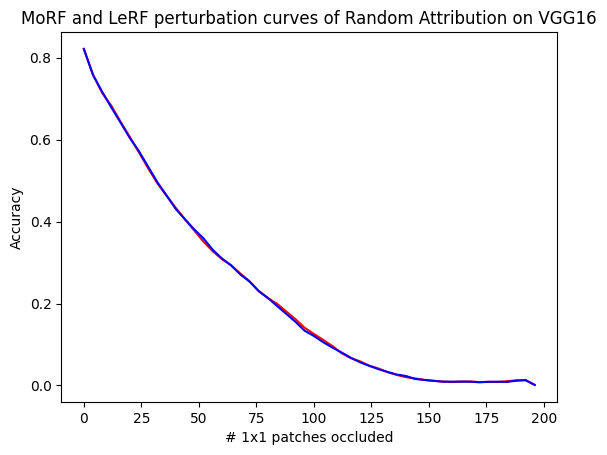

-0.0022440511474296648 2.398880091455669 2.4011241426030985


In [15]:
morf_preds_random, lerf_preds_random, _ = run_morf_lerf_occlusion_pixels(heatmaps=random_attrs, attr_name="Random", **default_args)